# Part one: For only one stock, detailed process
(Note: Next part will combine all stocks together)

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf

AAPL = yf.Ticker("AAPL")

# fast access to subset of stock info
AAPL.basic_info

lazy-loading dict with keys = ['currency', 'dayHigh', 'dayLow', 'exchange', 'fiftyDayAverage', 'lastPrice', 'lastVolume', 'marketCap', 'open', 'previousClose', 'quoteType', 'regularMarketPreviousClose', 'shares', 'tenDayAverageVolume', 'threeMonthAverageVolume', 'timezone', 'twoHundredDayAverage', 'yearChange', 'yearHigh', 'yearLow']

In [ ]:
import pandas as pd

In [ ]:
# slow access to all stock info
AAPL.info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscriptio

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [ ]:
import yfinance as yahooFinance


# in order to specify start date and
# end date we need datetime package
import datetime
from datetime import date

# startDate , as per our convenience we can modify
startDate = datetime.datetime(2018, 10, 12)

# endDate , as per our convenience we can modify
endDate = date.today()

#stock list
stock_list = ["AAPL","GOOG"]

#initialize returned data we want
stock_dict = {}

for stock in stock_list:

  #pass the parameters as the taken dates for start and end
  GetInformation = yahooFinance.Ticker(stock)
  stock_df = GetInformation.history(start=startDate,end=endDate)

  #Create stock_dict for future modeling and drawing plot purposes
  sub_stock_dict = {}
  sub_stock_dict['date'] = stock_df.index.values
  sub_stock_dict['value'] = stock_df.Close.values
  stock_dict[stock] = sub_stock_dict

  #Calculating the daily, monthly, and annulized volatility of the stock
  #The term “volatility” refers to the statistical measure of the dispersion of returns during a certain period of time for stocks, security, or market index.
  #The higher the volatilty, the higher the risk of the stock.
  stock_df['daily_returns']=(stock_df['Close'].pct_change()) * 100
  daily_returns = stock_df.daily_returns.values
  daily_returns = daily_returns[~np.isnan(daily_returns)] #delete the nan
  daily_volatility = np.std(daily_returns)
  monthly_volatility = math.sqrt(21) * daily_volatility
  annualized_volatility = math.sqrt(252) * daily_volatility
  print("Daily Volatility of", stock, 'is ', str(daily_volatility), "%")
  print("Monthly Volatility of", stock, 'is ', str(monthly_volatility), "%")
  print("Annualized Volatility of", stock, 'is ', str(annualized_volatility), "%")
  print("--------------------------------")


Daily Volatility of AAPL is  2.120355003263857 %
Monthly Volatility of AAPL is  9.716687302634963 %
Annualized Volatility of AAPL is  33.65959217884629 %
--------------------------------
Daily Volatility of GOOG is  2.04270408759656 %
Monthly Volatility of GOOG is  9.36084610380694 %
Annualized Volatility of GOOG is  32.42692210725358 %
--------------------------------


In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1)) # X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) --> X_scaled = X_std * (max - min) + min

import copy

stock_dict_normalized = copy.deepcopy(stock_dict)

sc.fit_transform(np.array(stock_dict_normalized[stock]['value']).reshape(-1, 1))

# scale the data
stock_dict_normalized['AAPL']['value'] = stock_dict_normalized['AAPL']['value'].reshape(stock_dict_normalized['AAPL']['value'].shape[0], 1)
stock_dict_normalized['AAPL']['value'] = sc.fit_transform(stock_dict_normalized['AAPL']['value'])

In [ ]:
#Create a function to process the data into 7 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)

X_list = []
y_list = []
for stock in stock_list:
  X, y = processData(stock_dict_normalized[stock]['value'], 7) #every X: past 7 days data --> every Y: new day's data (8th day)
  print(X.shape)
  print(y.shape)
  X_list.append(X)
  y_list.append(y)

(1192, 7)
(1192,)
(1192, 7)
(1192,)


In [ ]:
y.shape

(1192,)

In [ ]:
X_train_list = []
X_test_list = []
X_holdout_list = []
y_train_list = []
y_test_list = []
y_holdout_list = []

for i in range(len(stock_list)):
  X = X_list[i]
  y = y_list[i]
  X_train, X_test, X_holdout = X[:int(X.shape[0]*0.80 * 0.80)],X[int(X.shape[0]*0.80 * 0.80):int(X.shape[0]*0.80)], X[int(X.shape[0]*0.80):]
  y_train, y_test, y_holdout = y[:int(y.shape[0]*0.80 * 0.80)],y[int(y.shape[0]*0.80 * 0.80):int(y.shape[0]*0.80)], y[int(y.shape[0]*0.80):]

  # reshaping
  # X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  # X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

  X_train_list.append(X_train)
  X_test_list.append(X_test)
  X_holdout_list.append(X_holdout)
  y_train_list.append(y_train)
  y_test_list.append(y_test)
  y_holdout_list.append(y_holdout)

In [ ]:
print(X_train_list[0].shape, X_test_list[0].shape, X_holdout_list[0].shape)

(762, 7) (191, 7) (239, 7)


In [ ]:
input_shape=(X_train.shape[1], 1)
input_shape

(7, 1)

In [ ]:
y_train_list[0].shape

(762,)

In [ ]:
import tensorflow as tf
from tensorflow import keras

#define index
learning_rate = 0.001

# Building Model:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1))

# Compile
model.compile(loss=[tf.keras.losses.MeanSquaredError()], optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=[tf.keras.metrics.Accuracy()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 7, 50)             10400     
                                                                 
 dropout_8 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 7, 50)             20200     
                                                                 
 dropout_9 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_10 (LSTM)              (None, 7, 50)             20200     
                                                                 
 dropout_10 (Dropout)        (None, 7, 50)             0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [ ]:
model.fit(X_train_list[0], y_train_list[0], epochs=200, batch_size=32)

Epoch 1/200
24/24 [==============================] - 6s 15ms/step - loss: 0.0628 - accuracy: 0.0000e+00
Epoch 2/200
24/24 [==============================] - 0s 18ms/step - loss: 0.0069 - accuracy: 0.0000e+00
Epoch 3/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 4/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0031 - accuracy: 0.0000e+00
Epoch 5/200
24/24 [==============================] - 1s 22ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 6/200
24/24 [==============================] - 1s 22ms/step - loss: 0.0024 - accuracy: 0.0000e+00
Epoch 7/200
24/24 [==============================] - 0s 21ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 8/200
24/24 [==============================] - 0s 19ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 9/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0021 - accuracy: 0.0000e+00
Epoch 10/200
24/24 [==============================] - 0s 15ms/st

In [ ]:
model.predict(X_test_list[0]).shape

6/6 [==============================] - 3s 4ms/step


(191, 1)

In [ ]:
train_predict = model.predict(X_train_list[0])
test_predict = model.predict(X_test_list[0])

6/6 [==============================] - 0s 5ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test.reshape(-1,1),test_predict.reshape(-1,1))
print(f"Test Mean Squared Error (MSE): {mse}")
train_mse = mean_squared_error(y_train.reshape(-1,1),train_predict.reshape(-1,1))
print(f"Trian Mean Squared Error (MSE): {train_mse}")

Test Mean Squared Error (MSE): 0.013014852419965408
Trian Mean Squared Error (MSE): 0.014437731258544447


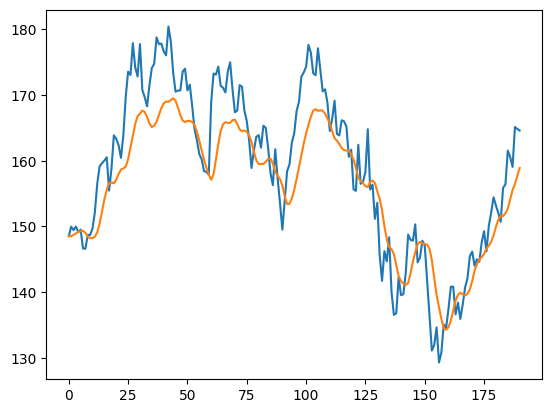

In [ ]:
plt.plot(sc.inverse_transform(y_test_list[0].reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict.reshape(-1,1)))

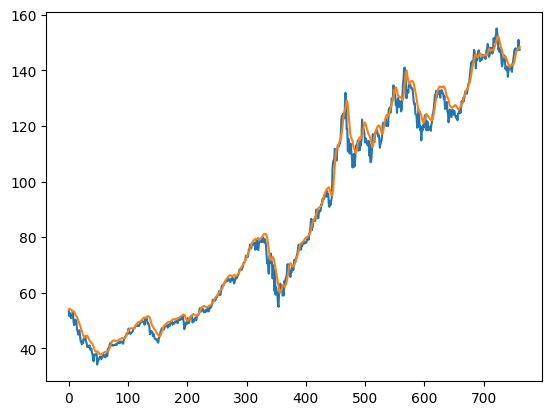

In [ ]:
plt.plot(sc.inverse_transform(y_train_list[0].reshape(-1,1)))
plt.plot(sc.inverse_transform(train_predict.reshape(-1,1)))

# Holdout performance

In [ ]:
holdout_predict = model.predict(X_holdout_list[0])
holdout_mse = mean_squared_error(y_holdout_list[0].reshape(-1,1),holdout_predict.reshape(-1,1))
print(f"Trian Mean Squared Error (MSE): {train_mse}")

8/8 [==============================] - 0s 6ms/step
Trian Mean Squared Error (MSE): 0.014437731258544447


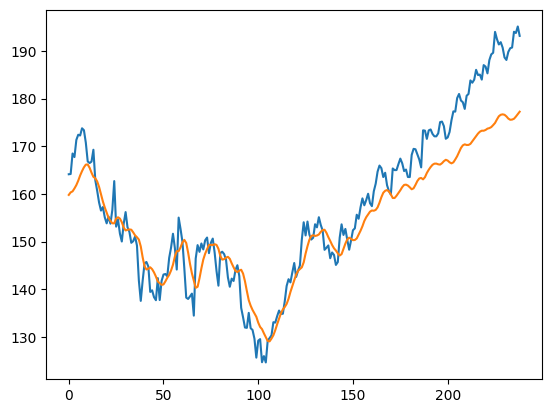

In [ ]:
plt.plot(sc.inverse_transform(y_holdout_list[0].reshape(-1,1)))
plt.plot(sc.inverse_transform(holdout_predict.reshape(-1,1)))

In [ ]:
Data_array = stock_dict_normalized["AAPL"]['date']
date_only_array = Data_array.astype('datetime64[D]')[8:]
date_only_array

array(['2018-10-24', '2018-10-25', '2018-10-26', ..., '2023-07-19',
       '2023-07-20', '2023-07-21'], dtype='datetime64[D]')

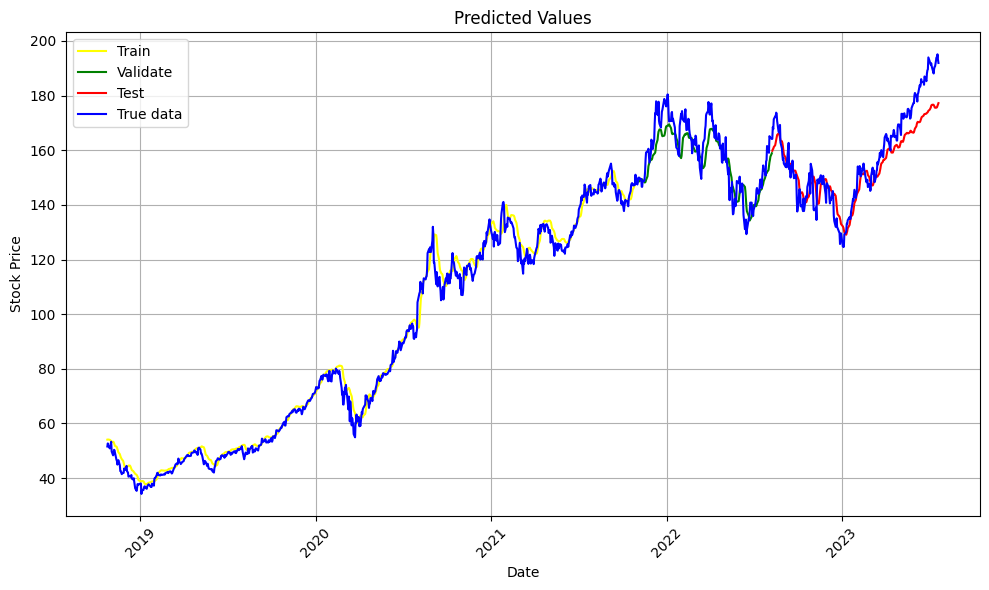

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

predicted_train = sc.inverse_transform(train_predict.reshape(-1,1))
predicted_test = sc.inverse_transform(test_predict.reshape(-1,1))
predicted_holdout = sc.inverse_transform(holdout_predict.reshape(-1,1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(date_only_array[:len(train_predict)], predicted_train, label='Train', color='yellow')
plt.plot(date_only_array[len(train_predict):len(train_predict) + len(test_predict)], predicted_test, label='Validate', color='green')
plt.plot(date_only_array[len(train_predict) + len(test_predict):], predicted_holdout, label='Test', color='red')
plt.plot(date_only_array, stock_dict["AAPL"]['value'][8:], label='True data', color='Blue')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Part two: Analyze the stock price vs Volatility
Does Higher Volatility stock indeed harder to predict?

## Step1. Pulling data from yfinance API and calculate Volatility

In [4]:
import yfinance as yahooFinance
import tensorflow as tf
from tensorflow import keras

# in order to specify start date and
# end date we need datetime package
import datetime
from datetime import date, timedelta

# Get today's date
endDate = date.today()

# Subtract 5 years from today's date
startDate = endDate - timedelta(days=365 * 5)

#stock list
stock_list = ["AAPL","MSFT","AMZN", "NVDA", "TSLA", "GOOGL", "META","JPM"]

#initialize returned data we want
stock_dict = {}
volatility_dict = {}

for stock in stock_list:

  #pass the parameters as the taken dates for start and end
  GetInformation = yahooFinance.Ticker(stock)
  stock_df = GetInformation.history(start=startDate,end=endDate)

  #Create stock_dict for future modeling and drawing plot purposes
  sub_stock_dict = {}
  sub_stock_dict['date'] = stock_df.index.values
  sub_stock_dict['value'] = stock_df.Close.values
  stock_dict[stock] = sub_stock_dict

  #Calculating the daily, monthly, and annulized volatility of the stock
  #The term “volatility” refers to the statistical measure of the dispersion of returns during a certain period of time for stocks, security, or market index.
  #The higher the volatilty, the higher the risk of the stock.
  stock_df['daily_returns']=(stock_df['Close'].pct_change()) * 100
  daily_returns = stock_df.daily_returns.values
  daily_returns = daily_returns[~np.isnan(daily_returns)] #delete the nan
  daily_volatility = np.std(daily_returns)
  monthly_volatility = math.sqrt(21) * daily_volatility
  annualized_volatility = math.sqrt(252) * daily_volatility
  print("Daily Volatility of", stock, 'is ', str(daily_volatility), "%")
  print("Monthly Volatility of", stock, 'is ', str(monthly_volatility), "%")
  print("Annualized Volatility of", stock, 'is ', str(annualized_volatility), "%")
  print("--------------------------------")

  sub_volatility_dict = {}
  sub_volatility_dict['daily_volatility'] = daily_volatility
  sub_volatility_dict['monthly_volatility'] = monthly_volatility
  sub_volatility_dict['annualized_volatility'] = annualized_volatility
  volatility_dict[stock] = sub_volatility_dict

Daily Volatility of AAPL is  2.099593965871719 %
Monthly Volatility of AAPL is  9.62154827727968 %
Annualized Volatility of AAPL is  33.33002092745043 %
--------------------------------
Daily Volatility of MSFT is  1.9688830586618289 %
Monthly Volatility of MSFT is  9.02255565083401 %
Annualized Volatility of MSFT is  31.255049602724373 %
--------------------------------
Daily Volatility of AMZN is  2.2992146257850696 %
Monthly Volatility of AMZN is  10.536325061609647 %
Annualized Volatility of AMZN is  36.49890066353838 %
--------------------------------
Daily Volatility of NVDA is  3.384338554263218 %
Monthly Volatility of NVDA is  15.50898760226861 %
Annualized Volatility of NVDA is  53.7247090021701 %
--------------------------------
Daily Volatility of TSLA is  4.197872770956975 %
Monthly Volatility of TSLA is  19.237069730704356 %
Annualized Volatility of TSLA is  66.63916432465058 %
--------------------------------
Daily Volatility of GOOGL is  2.015217351254803 %
Monthly Volat

## Step2. Model pipeline

In [6]:
from sklearn.preprocessing import MinMaxScaler
import copy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Create a function to process the data into 7 day look back slices
def processData(data, lb):
  X, Y = [], []
  for i in range(len(data) - lb - 1):
      X.append(data[i: (i + lb), 0])
      Y.append(data[(i + lb), 0])
  return np.array(X), np.array(Y)

def Get_LSTM_Dict(stock_dict):
  results_dict = {}
  for stock in stock_list:
    sc = MinMaxScaler(feature_range = (0, 1)) # X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) --> X_scaled = X_std * (max - min) + min
    stock_dict_normalized = copy.deepcopy(stock_dict)
    sc.fit_transform(np.array(stock_dict_normalized[stock]['value']).reshape(-1, 1))
    # scale the data
    stock_dict_normalized[stock]['value'] = stock_dict_normalized[stock]['value'].reshape(stock_dict_normalized[stock]['value'].shape[0], 1)
    stock_dict_normalized[stock]['value'] = sc.fit_transform(stock_dict_normalized[stock]['value'])

    #Get X and y using above udf: X: Day 1 to Day 7 , y: Day 8
    X, y = processData(stock_dict_normalized[stock]['value'], 7) #every X: past 7 days data --> every Y: new day's data (8th day)
    X_train, X_test, X_holdout = X[:int(X.shape[0]*0.80 * 0.80)],X[int(X.shape[0]*0.80 * 0.80):int(X.shape[0]*0.80)], X[int(X.shape[0]*0.80):]
    y_train, y_test, y_holdout = y[:int(y.shape[0]*0.80 * 0.80)],y[int(y.shape[0]*0.80 * 0.80):int(y.shape[0]*0.80)], y[int(y.shape[0]*0.80):]

    #define index
    learning_rate = 0.001

    # Building LSTM Model:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=50))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=1))

    # Compile Model
    model.compile(loss=[tf.keras.losses.MeanSquaredError()], optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=[tf.keras.metrics.Accuracy()])

    #train
    print("Start training")
    model.fit(X_train, y_train, epochs=200, batch_size=32)
    print(f"successfully trained model for {stock}")

    #predict
    train_predict = sc.inverse_transform(model.predict(X_train))
    test_predict = sc.inverse_transform(model.predict(X_test))
    holdout_predict = sc.inverse_transform(model.predict(X_holdout)) #for similicity, does not tune hyperparameter here, we directly evaluate the holdout

    #evaluate
    print(f"Now evaluate the model for {stock}: ")
    test_mape = mean_absolute_percentage_error(sc.inverse_transform(y_test.reshape(-1,1)),test_predict)
    print(f"Test Mean Absolute Percentage Error (MAPE): {test_mape}")
    train_mape = mean_absolute_percentage_error(sc.inverse_transform(y_train.reshape(-1,1)),train_predict)
    print(f"Train Mean Absolute Percentage Error (MAPE): {train_mape}")
    holdout_mape = mean_absolute_percentage_error(sc.inverse_transform(y_holdout.reshape(-1,1)),holdout_predict)
    print(f"holdout Mean Absolute Percentage Error (MAPE): {holdout_mape}")

    #append data into results dataframe
    sub_df = {}
    sub_df["test_mape"] = test_mape
    sub_df["train_mape"] = train_mape
    sub_df["holdout_mape"] = holdout_mape
    sub_df["predicted_train"] = train_predict
    sub_df["predicted_test"] = test_predict
    sub_df["predicted_holdout"] = holdout_predict
    results_dict[stock] = sub_df

    print(f"{stock} all done!")
  print("All Done!")
  return results_dict

In [7]:
LSTM_dict_new = Get_LSTM_Dict(stock_dict)

Start training
Epoch 1/200
25/25 [==============================] - 9s 24ms/step - loss: 0.0530 - accuracy: 0.0000e+00
Epoch 2/200
25/25 [==============================] - 1s 25ms/step - loss: 0.0081 - accuracy: 0.0000e+00
Epoch 3/200
25/25 [==============================] - 1s 41ms/step - loss: 0.0031 - accuracy: 0.0000e+00
Epoch 4/200
25/25 [==============================] - 2s 75ms/step - loss: 0.0024 - accuracy: 0.0000e+00
Epoch 5/200
25/25 [==============================] - 1s 58ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 6/200
25/25 [==============================] - 1s 44ms/step - loss: 0.0020 - accuracy: 0.0000e+00
Epoch 7/200
25/25 [==============================] - 1s 42ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 8/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0017 - accuracy: 0.0000e+00
Epoch 9/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0019 - accuracy: 0.0000e+00
Epoch 10/200
25/25 [=============================

Start training
Epoch 1/200
25/25 [==============================] - 8s 24ms/step - loss: 0.0481 - accuracy: 0.0000e+00
Epoch 2/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0051 - accuracy: 0.0000e+00
Epoch 3/200
25/25 [==============================] - 1s 24ms/step - loss: 0.0030 - accuracy: 0.0000e+00
Epoch 4/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 5/200
25/25 [==============================] - 1s 35ms/step - loss: 0.0021 - accuracy: 0.0000e+00
Epoch 6/200
25/25 [==============================] - 1s 35ms/step - loss: 0.0019 - accuracy: 0.0000e+00
Epoch 7/200
25/25 [==============================] - 1s 34ms/step - loss: 0.0020 - accuracy: 0.0000e+00
Epoch 8/200
25/25 [==============================] - 1s 37ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 9/200
25/25 [==============================] - 1s 44ms/step - loss: 0.0018 - accuracy: 0.0000e+00
Epoch 10/200
25/25 [=============================

Start training
Epoch 1/200
25/25 [==============================] - 9s 22ms/step - loss: 0.1121 - accuracy: 0.0000e+00
Epoch 2/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0154 - accuracy: 0.0000e+00
Epoch 3/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0073 - accuracy: 0.0000e+00
Epoch 4/200
25/25 [==============================] - 1s 24ms/step - loss: 0.0054 - accuracy: 0.0000e+00
Epoch 5/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0063 - accuracy: 0.0000e+00
Epoch 6/200
25/25 [==============================] - 1s 24ms/step - loss: 0.0048 - accuracy: 0.0000e+00
Epoch 7/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0050 - accuracy: 0.0000e+00
Epoch 8/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0049 - accuracy: 0.0000e+00
Epoch 9/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0048 - accuracy: 0.0000e+00
Epoch 10/200
25/25 [=============================

Start training
Epoch 1/200
25/25 [==============================] - 10s 27ms/step - loss: 0.0122 - accuracy: 0.0000e+00
Epoch 2/200
25/25 [==============================] - 1s 26ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 3/200
25/25 [==============================] - 1s 26ms/step - loss: 0.0011 - accuracy: 0.0000e+00
Epoch 4/200
25/25 [==============================] - 1s 26ms/step - loss: 5.0569e-04 - accuracy: 0.0000e+00
Epoch 5/200
25/25 [==============================] - 1s 27ms/step - loss: 6.1033e-04 - accuracy: 0.0000e+00
Epoch 6/200
25/25 [==============================] - 1s 26ms/step - loss: 5.2160e-04 - accuracy: 0.0000e+00
Epoch 7/200
25/25 [==============================] - 1s 27ms/step - loss: 4.4873e-04 - accuracy: 0.0000e+00
Epoch 8/200
25/25 [==============================] - 1s 26ms/step - loss: 5.8353e-04 - accuracy: 0.0000e+00
Epoch 9/200
25/25 [==============================] - 1s 26ms/step - loss: 4.4498e-04 - accuracy: 0.0000e+00
Epoch 10/200
25/25 [====

Start training
Epoch 1/200
25/25 [==============================] - 10s 35ms/step - loss: 0.0386 - accuracy: 0.0000e+00
Epoch 2/200
25/25 [==============================] - 1s 34ms/step - loss: 0.0042 - accuracy: 0.0000e+00
Epoch 3/200
25/25 [==============================] - 1s 34ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 4/200
25/25 [==============================] - 1s 26ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 5/200
25/25 [==============================] - 1s 25ms/step - loss: 0.0019 - accuracy: 0.0000e+00
Epoch 6/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0018 - accuracy: 0.0000e+00
Epoch 7/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0018 - accuracy: 0.0000e+00
Epoch 8/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0017 - accuracy: 0.0000e+00
Epoch 9/200
25/25 [==============================] - 1s 23ms/step - loss: 0.0014 - accuracy: 0.0000e+00
Epoch 10/200
25/25 [============================

Start training
Epoch 1/200
25/25 [==============================] - 9s 24ms/step - loss: 0.0510 - accuracy: 0.0000e+00
Epoch 2/200
25/25 [==============================] - 1s 24ms/step - loss: 0.0042 - accuracy: 0.0000e+00
Epoch 3/200
25/25 [==============================] - 1s 24ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 4/200
25/25 [==============================] - 1s 24ms/step - loss: 0.0031 - accuracy: 0.0000e+00
Epoch 5/200
25/25 [==============================] - 1s 24ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 6/200
25/25 [==============================] - 1s 24ms/step - loss: 0.0026 - accuracy: 0.0000e+00
Epoch 7/200
25/25 [==============================] - 1s 24ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 8/200
25/25 [==============================] - 1s 33ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 9/200
25/25 [==============================] - 1s 35ms/step - loss: 0.0024 - accuracy: 0.0000e+00
Epoch 10/200
25/25 [=============================

Start training
Epoch 1/200
25/25 [==============================] - 10s 28ms/step - loss: 0.0874 - accuracy: 0.0000e+00
Epoch 2/200
25/25 [==============================] - 1s 28ms/step - loss: 0.0167 - accuracy: 0.0000e+00
Epoch 3/200
25/25 [==============================] - 1s 27ms/step - loss: 0.0053 - accuracy: 0.0000e+00
Epoch 4/200
25/25 [==============================] - 1s 29ms/step - loss: 0.0045 - accuracy: 0.0000e+00
Epoch 5/200
25/25 [==============================] - 1s 37ms/step - loss: 0.0047 - accuracy: 0.0000e+00
Epoch 6/200
25/25 [==============================] - 1s 39ms/step - loss: 0.0040 - accuracy: 0.0000e+00
Epoch 7/200
25/25 [==============================] - 1s 40ms/step - loss: 0.0041 - accuracy: 0.0000e+00
Epoch 8/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 9/200
25/25 [==============================] - 1s 28ms/step - loss: 0.0041 - accuracy: 0.0000e+00
Epoch 10/200
25/25 [============================

Start training
Epoch 1/200
25/25 [==============================] - 10s 29ms/step - loss: 0.0820 - accuracy: 0.0000e+00
Epoch 2/200
25/25 [==============================] - 1s 29ms/step - loss: 0.0118 - accuracy: 0.0000e+00
Epoch 3/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0066 - accuracy: 0.0000e+00
Epoch 4/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0056 - accuracy: 0.0000e+00
Epoch 5/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0055 - accuracy: 0.0000e+00
Epoch 6/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0049 - accuracy: 0.0000e+00
Epoch 7/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0046 - accuracy: 0.0000e+00
Epoch 8/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 9/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0050 - accuracy: 0.0000e+00
Epoch 10/200
25/25 [============================

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def draw_prediction_graph(predicted_train,predicted_test,predicted_holdout,original_price, date_range, stock_name):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(date_range[:len(predicted_train)], predicted_train, label='Train', color='yellow')
    plt.plot(date_range[len(predicted_train):len(predicted_train) + len(predicted_test)], predicted_test, label='Validate', color='green')
    plt.plot(date_range[len(predicted_train) + len(predicted_test):], predicted_holdout, label='Test', color='red')
    plt.plot(date_range, stock_dict[stock_name]['value'][8:], label='True data', color='Blue')

    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(f'Predicted Values for {stock_name}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def draw_prediction_charts_all(LSTM_dict, stock_dict):
    for stock in LSTM_dict.keys():
      date_range = stock_dict[stock]['date']
      date_range= date_range.astype('datetime64[D]')[8:]
      draw_prediction_graph(LSTM_dict[stock]["predicted_train"],LSTM_dict[stock]["predicted_test"],LSTM_dict[stock]["predicted_holdout"], stock_dict[stock]["value"],date_range, stock)


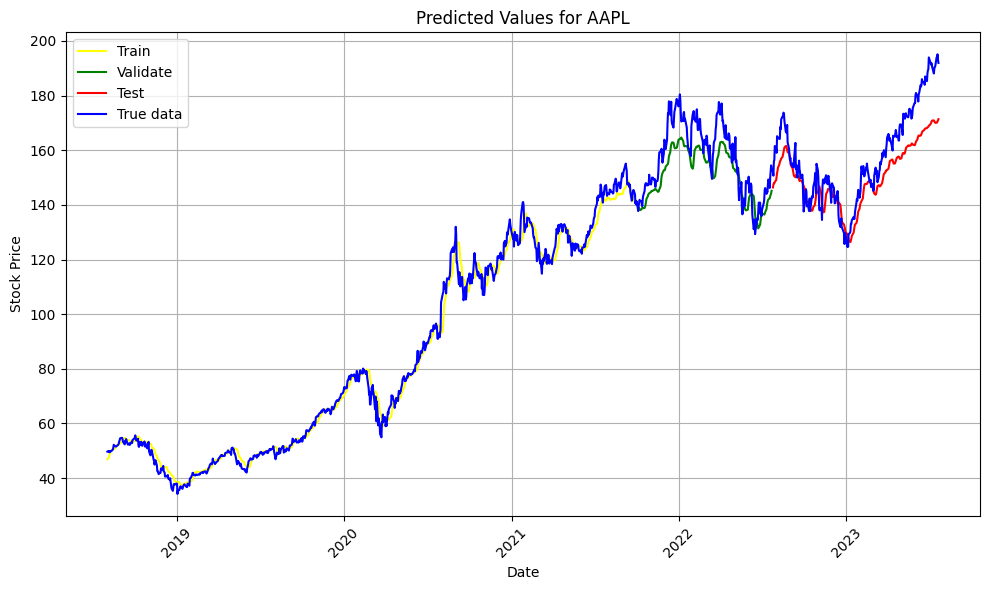

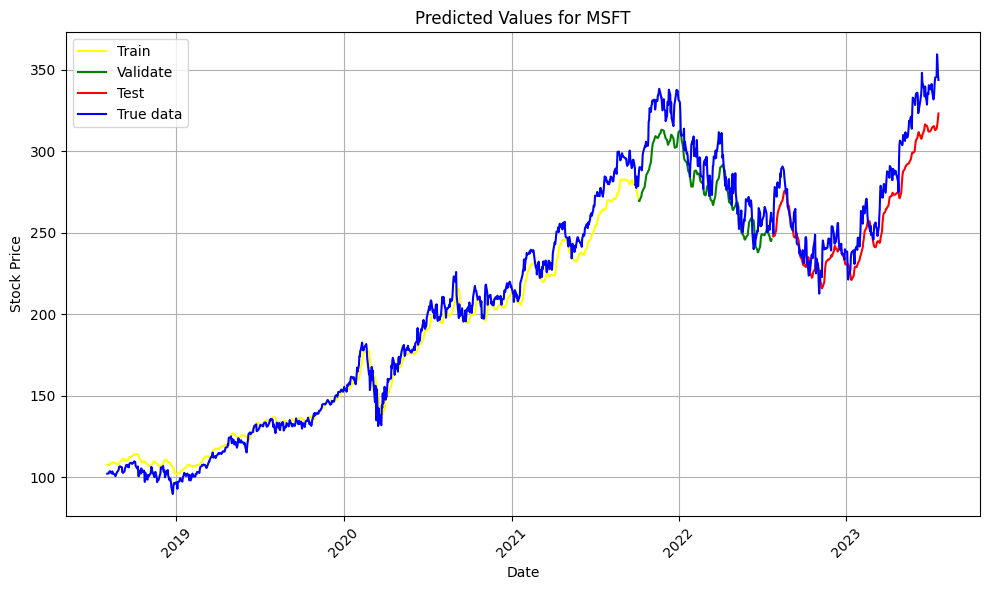

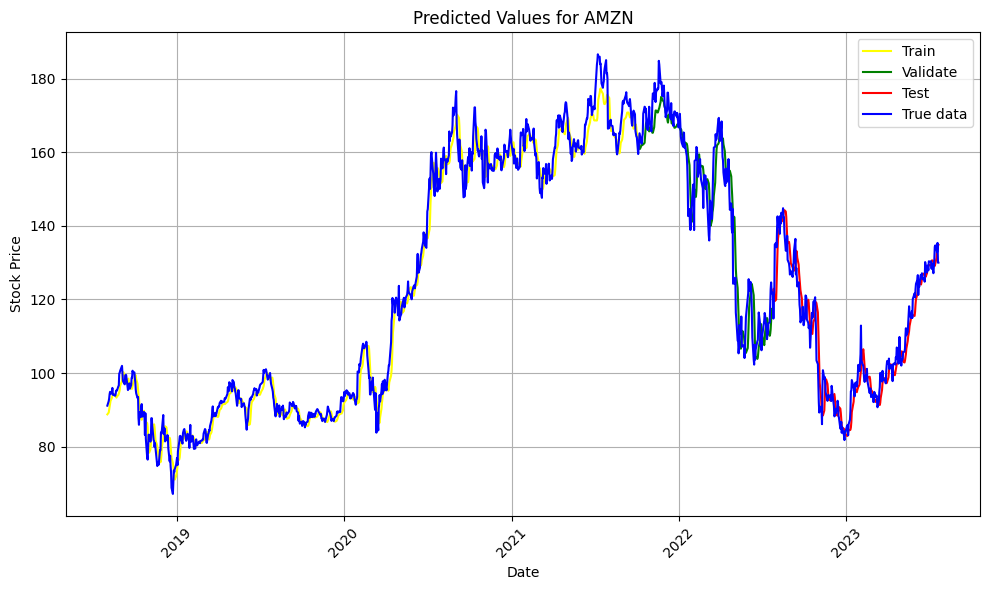

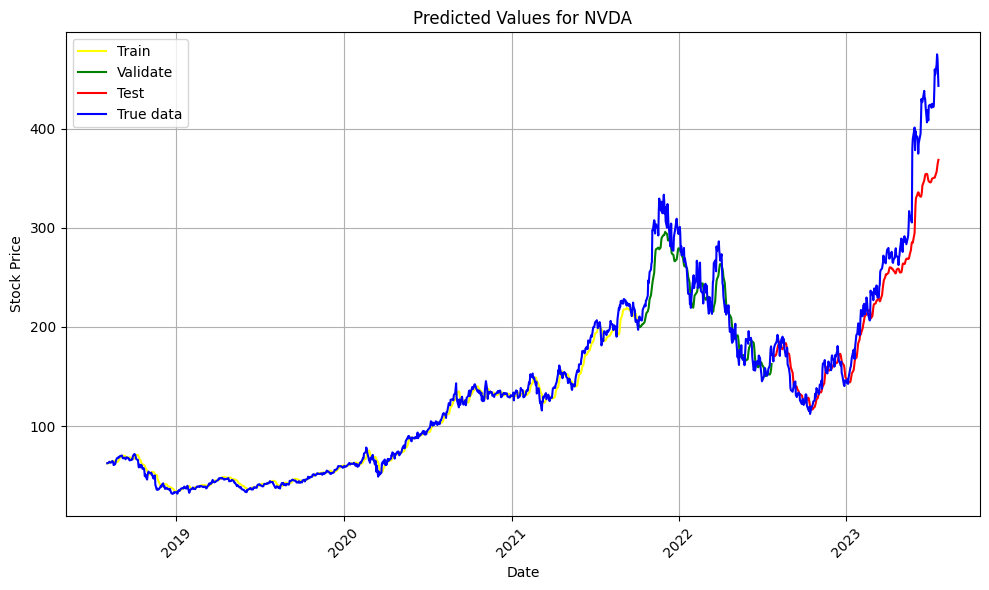

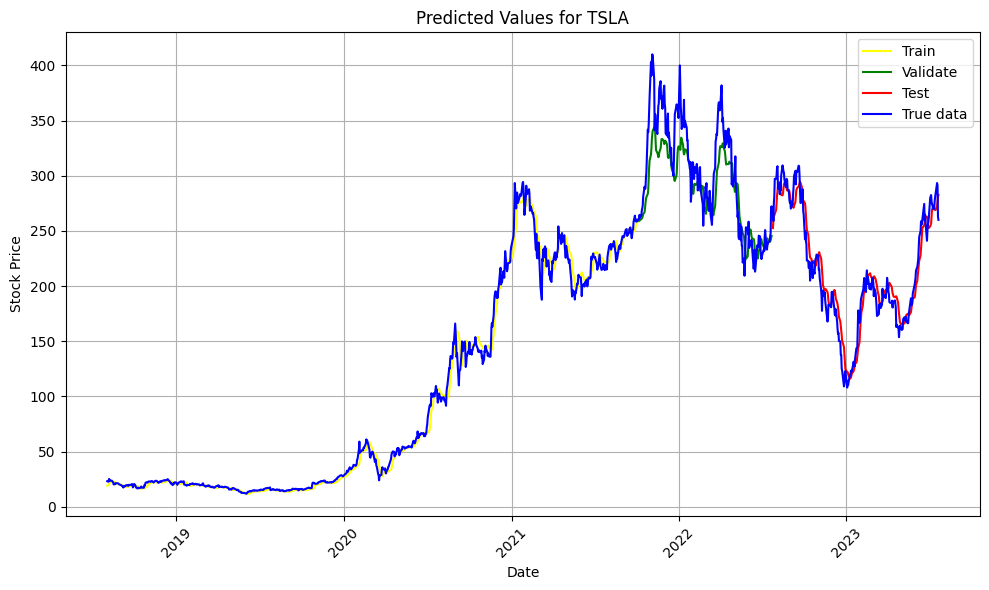

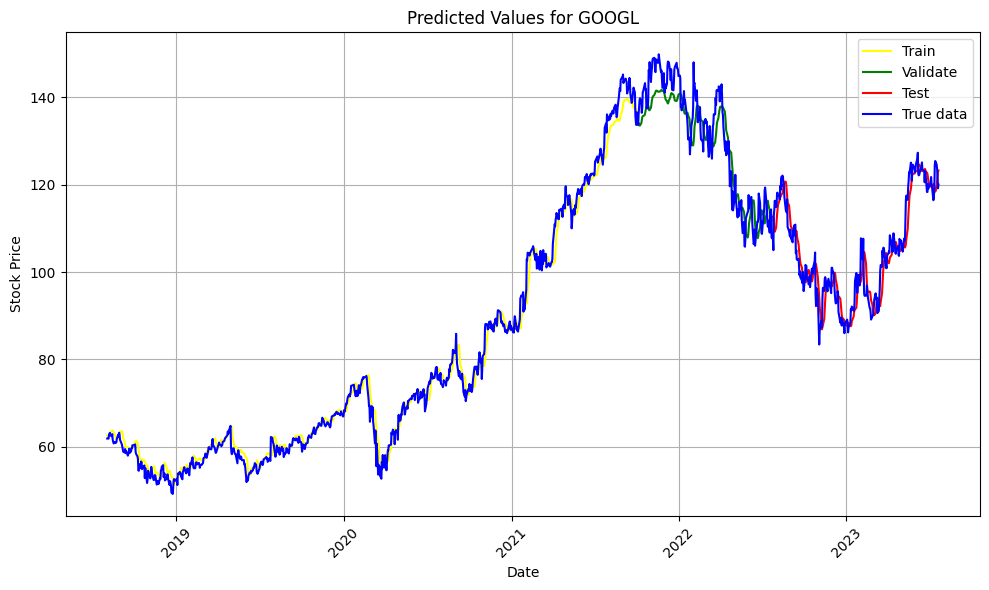

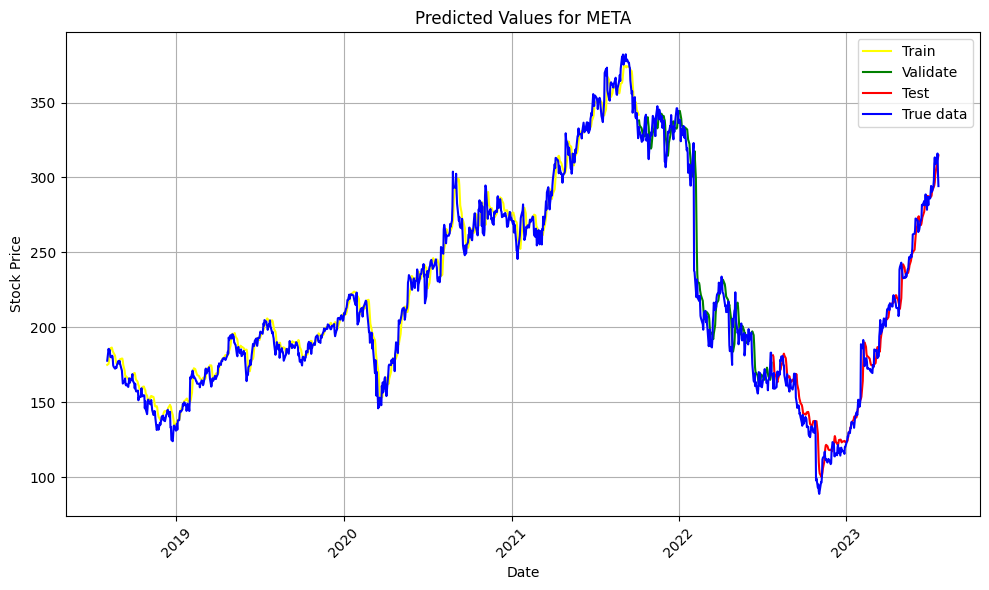

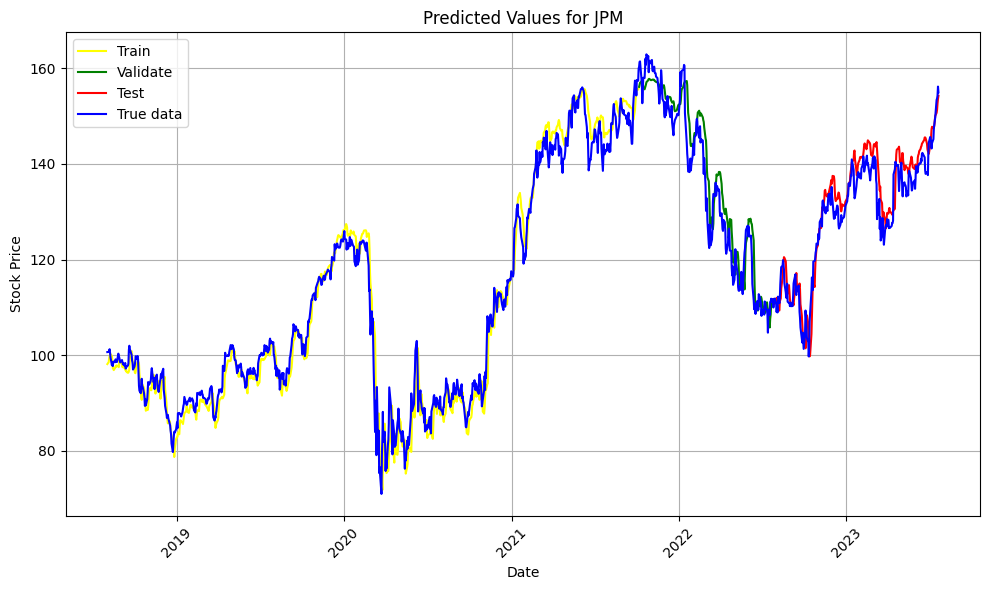

In [ ]:
draw_prediction_charts_all(LSTM_dict_new,stock_dict)

# Analyze Volatility vs MSE

In [10]:
import pandas as pd

In [9]:
LSTM_dict_MSE = {}
for stock in LSTM_dict_new.keys():
  # List of keys to keep
  keys_to_keep = ['train_mape', 'test_mape','holdout_mape']
  # Create a new dictionary with the desired keys
  filtered_dict = {key: LSTM_dict_new[stock][key] for key in keys_to_keep}
  LSTM_dict_MSE[stock] = filtered_dict
MSE_df = pd.DataFrame(LSTM_dict_MSE).T
volatility_df = pd.DataFrame(volatility_dict).T
combined = pd.concat([MSE_df,volatility_df], axis = 1)
combined

,train_mape,test_mape,holdout_mape,daily_volatility,monthly_volatility,annualized_volatility
AAPL,0.031612,0.027341,0.032582,2.099594,9.621548,33.330021
MSFT,0.018426,0.023650,0.025341,1.968883,9.022556,31.255050
AMZN,0.018754,0.030204,0.024801,2.299215,10.536325,36.498901
NVDA,0.031599,0.048063,0.058073,3.384339,15.508988,53.724709
TSLA,0.051499,0.082318,0.051808,4.197873,19.237070,66.639164
GOOGL,0.024274,0.036741,0.042853,2.015217,9.234886,31.990584
META,0.021720,0.035809,0.036640,2.830024,12.968798,44.925234
JPM,0.015709,0.019104,0.013897,2.028439,9.295474,32.200465


In [17]:
# AVERAGE mape value
print(combined.holdout_mape.mean())

0.035749459023306604


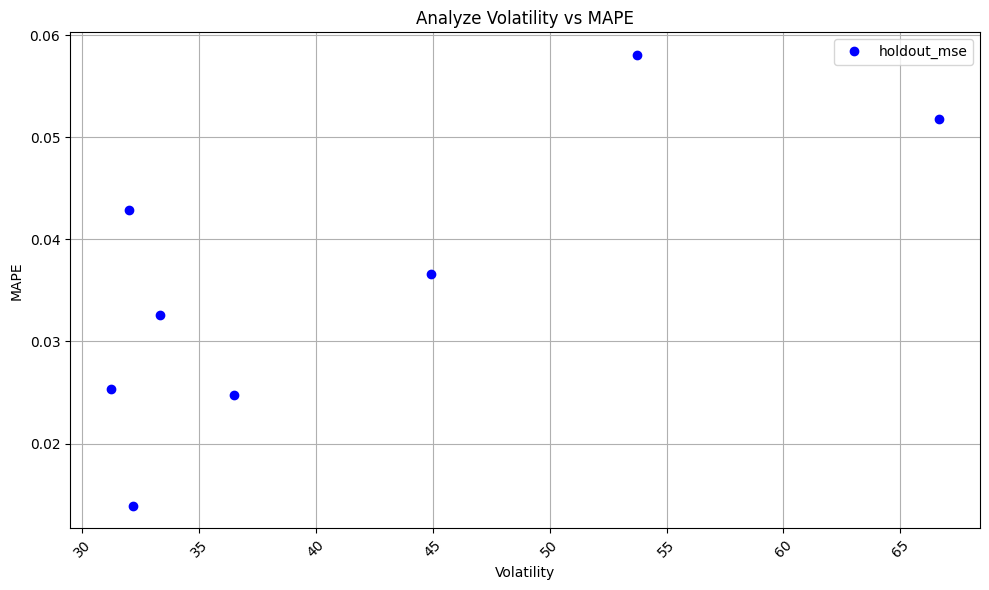

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(combined.annualized_volatility, combined.holdout_mape, 'o',label='holdout_mse', color='blue')

plt.xlabel('Volatility')
plt.ylabel('MAPE')
plt.title(f'Analyze Volatility vs MAPE')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Base on results: Higher Volatility indeed has a positive realtionship with MAPE, meaning it is harder to predict unstable stock